# A first look at the MPI data

Our MPI data is quite out of date. Max and Joe had a meeting with key people in charge of the dataset at OPHI. We were provided with a csv and codebook (see 'Original' folder) by Nicolai and Usha at OPHI in email correspondence.

The idea is for us to take a look and then get back to them with any requests about the structure of the data.

## Set up

In [2]:
##I use this package for charts
# pip install plotnine

### Import

In [3]:
import pandas as pd
from plotnine import *

In [4]:
#read original data file provided by Nicolai and Usha
df = pd.read_csv('Original/GMPI2021_publicuse.csv')

### Standardize country names

In [5]:
# df.head()

## Export to pass through country name tool
# df[['cty_lab']].rename(columns={'cty_lab': 'country'}).drop_duplicates().to_csv("Manipulation/MPI countries.csv", index = False)

# Grab country name mapping csv
country_names_map = pd.read_csv("Manipulation/MPI countries_country_standardized.csv")

# Merge into main data
df = pd.merge(df.rename(columns={'cty_lab': 'country'}),country_names_map,how='left', on='country')

# Swap country vars over
df = df.drop(columns='country')
df = df.rename(columns={'Our World In Data Name': 'country'})

# Rearrange columns
df = df[["year", "country", "area_lab", "flav", "t", "measure_lab",  "ind_lab", "b", "se", "indicator", "measure", "survey", "loa", "w_region", "k", "wgts", "spec",  "misind_lab"]]



## The structure of the data

In [6]:
df.head()

,year,country,area_lab,flav,t,measure_lab,ind_lab,b,se,indicator,measure,survey,loa,w_region,k,wgts,spec,misind_lab
0,2018-2019,Algeria,National,cme,NaN,MPI,NaN,0.005409,.0006646200004152,NaN,M0,MICS,nat,Arab States,33.0,equal,gmpi,NaN
1,2018-2019,Algeria,National,cme,NaN,Headcount ratio,NaN,1.380835,.15076397587442,NaN,H,MICS,nat,Arab States,33.0,equal,gmpi,NaN
2,2018-2019,Algeria,National,cme,NaN,Intensity,NaN,39.172628,.96566740646732,NaN,A,MICS,nat,Arab States,33.0,equal,gmpi,NaN
3,2018-2019,Algeria,National,cme,NaN,Uncensored headcount ratio,Nutrition,5.825295,.25438270613317,d_nutr,hd,MICS,nat,Arab States,NaN,NaN,gmpi,NaN
4,2018-2019,Algeria,National,cme,NaN,Uncensored headcount ratio,Child mortality,1.138596,.08131516325524,d_cm,hd,MICS,nat,Arab States,NaN,NaN,gmpi,NaN


The data is arranged by country, area, year and measure.

Area is coded in `area_lab` and is set to one of 'National', 'Rural' or 'Urban' (NB. Palestine (alone) has some rows where `area = 'Camp'`).

`year` is a string variable that often covers a two year period (reflecting the fact that the survey was spread over two calendar years). This is discussed more below.

There are 8 different measures, given in `measure_lab`.


In [7]:
print("Count of countries with observations for each measure and area breakdown")
# Count unique countries by measure, and pivot by area
df.groupby(['measure_lab', 'area_lab'], as_index=False).agg({"country":"nunique"})\
   .rename(columns={'country':'unique_countries'})\
   .pivot_table(index = ["measure_lab"],
                columns = ["area_lab"],
                values = "unique_countries").reset_index()
   

Count of countries with observations for each measure and area breakdown


area_lab,measure_lab,Camp,National,Rural,Urban
0,Absolute contribution,1.0,109.0,108.0,108.0
1,Censored headcount ratio,1.0,109.0,108.0,108.0
2,Headcount ratio,1.0,109.0,108.0,108.0
3,Intensity,1.0,109.0,108.0,107.0
4,MPI,1.0,109.0,108.0,108.0
5,Population share,1.0,NaN,108.0,108.0
6,Relative contribution,1.0,109.0,108.0,107.0
7,Uncensored headcount ratio,1.0,109.0,108.0,108.0


#### Note on `year` 

The way `year` is formatted – as a string variable often spanning two calendar years – won't work with our schema.

For now, arbitrarily, I take the first year in these cases and convert to integer.

In [8]:
# First year = first 4 characters of the year string
df['year'] = df['year'].str[:4].astype(int)
# df.head()

But maybe we should suggest to OPHI that they do it in the way Povcal do it:

Povcal resolve this by providing the year as e.g. 2011.75 – where the integer is the first calendar year and the decimal is the share of the second calendar year over which the survey took place. So if the survey occured for 3 months in 2011 and 9 months in 2012 the year would be recorded as 2011.75 (9/12 = 0.75). This allows the `year` variable to be rounded where 'rounding' effectively means selecting the year in which the bulk of the survey fell.
(Note that Povcal only code this in terms of the start and end date of the survey. This might not reflect the actual distribution of when the surveys happened if they weren't evenly distributed across full period).

We could ask OPHI to add a second year variable like the one Povcal makes available.

#### Note on `flav`
Due to changing data coverage across surveys, OPHI produce two sets of estiamtes: point estimates for single years (`flav = cme` – "current marginal estimates") and estiamtes intended to track change over time (`flav = hot` – "harmonized over time"). The latter are based on the subset of survey data that is available across all years. The former is considered the most accurated for the most recent year.

Note that the values can and do differ between these two sets of data. For instance, the MPI in Indonesia in 2017: 

In [9]:
df.loc[(df.country=="Indonesia")\
       & (df.measure_lab=="MPI")\
       & (df.area_lab=="National")\
       & (df.year==2017)]

,year,country,area_lab,flav,t,measure_lab,ind_lab,b,se,indicator,measure,survey,loa,w_region,k,wgts,spec,misind_lab
1703,2017,Indonesia,National,cme,NaN,MPI,NaN,0.014011,.00064430683492,NaN,M0,DHS,nat,East Asia and the Pacific,33.0,equal,gmpi,Nutrition
17932,2017,Indonesia,National,hot,2.0,MPI,NaN,0.013904,.0006524594428253,NaN,M0,DHS,nat,East Asia and the Pacific,33.0,equal,gmpi,Nutrition


##### `hot` data
'Harmonized over time' rows are given an ordering variable – `t  ∈ {1,2,3}` – as well as `year`.

In [10]:
df.loc[df.flav=="hot"].head()

,year,country,area_lab,flav,t,measure_lab,ind_lab,b,se,indicator,measure,survey,loa,w_region,k,wgts,spec,misind_lab
14923,2018,Algeria,National,hot,2.0,MPI,NaN,0.005409,.0006685386028565,NaN,M0,MICS,nat,Arab States,33.0,equal,gmpi,NaN
14924,2012,Algeria,National,hot,1.0,MPI,NaN,0.008094,.0006496337442475,NaN,M0,MICS,nat,Arab States,33.0,equal,gmpi,NaN
14925,2018,Algeria,National,hot,2.0,Headcount ratio,NaN,1.380835,.15185259077076,NaN,H,MICS,nat,Arab States,33.0,equal,gmpi,NaN
14926,2012,Algeria,National,hot,1.0,Headcount ratio,NaN,2.104967,.15927227976071,NaN,H,MICS,nat,Arab States,33.0,equal,gmpi,NaN
14927,2018,Algeria,National,hot,2.0,Intensity,NaN,39.172628,.9659168247875599,NaN,A,MICS,nat,Arab States,33.0,equal,gmpi,NaN


Most countries only have two distinct years with observations. But about 1/3rd have three.

In [11]:
n_years = df.loc[df.flav=="hot"].groupby('country', as_index=False)\
            .agg({"year":"nunique"}).rename(columns={'year':'unique_years'})

country_group_n_years = n_years.groupby('unique_years', as_index=False)\
                               .agg({"country":"nunique"})\
                               .rename(columns={'countr':'countries_count'})

country_group_n_years.head()


,unique_years,country
0,2,56
1,3,28


In [12]:
# # Examples of countries with three year observations
# n_years.loc[n_years.unique_years>2].head()

Bolivia is an example of a country with three observations.

In [13]:
df.loc[(df.flav=="hot") & (df.country=="Bolivia")].head()

,year,country,area_lab,flav,t,measure_lab,ind_lab,b,se,indicator,measure,survey,loa,w_region,k,wgts,spec,misind_lab
24436,2008,Bolivia,National,hot,2.0,MPI,NaN,0.095269,.0042190183530881,NaN,M0,DHS,nat,Latin America and the Caribbean,33.0,equal,gmpi,NaN
24437,2016,Bolivia,National,hot,3.0,MPI,NaN,0.037981,.0026044656413404,NaN,M0,EDSA,nat,Latin America and the Caribbean,33.0,equal,gmpi,NaN
24438,2003,Bolivia,National,hot,1.0,MPI,NaN,0.166650,.0048158416730058,NaN,M0,DHS,nat,Latin America and the Caribbean,33.0,equal,gmpi,NaN
24439,2016,Bolivia,National,hot,3.0,Headcount ratio,NaN,9.102748,.59002076359525,NaN,H,EDSA,nat,Latin America and the Caribbean,33.0,equal,gmpi,NaN
24440,2008,Bolivia,National,hot,2.0,Headcount ratio,NaN,20.616171,.81085897120585,NaN,H,DHS,nat,Latin America and the Caribbean,33.0,equal,gmpi,NaN


##### `cme` data
For 'Current marginal estiamtes', only the latest year from the `hot` data is included and `t = NaN`.

Note that not all countries have `hot` data (e.g. Angola).


In [14]:
df.groupby(["country","flav"]).agg({"year":["min", "max"]}).head(n=8)

year      
                   min   max
country     flav            
Afghanistan cme   2015  2015
            hot   2010  2015
Albania     cme   2017  2017
            hot   2008  2017
Algeria     cme   2018  2018
            hot   2012  2018
Angola      cme   2015  2015
Armenia     cme   2015  2015

## Multi-dimesional poverty measures

At least initially, we will be primarily concerned with the three measures that relate to overall multi-dimensional poverty:
- `Headcount ratio`: the share of population in multidimensional poverty
- `Intensity`: a measure of the average depth of poverty (of the poor only – NB, not like Povcal's poverty gap index)
- `MPI`: the product of `Headcount ratio` and `Intensity`.

These are multi-dimensional poverty measures – a weighted aggregation across many individual indicators.

Here I prepare this data as I would for uploading to OWID grapher and visualize it – separating the `hot` from the `cme` data.

In [15]:
# Prep data for OWID

# filter for main multi-dimensional pov measures
df_main = df.loc[(df['measure_lab'].isin(["MPI", "Intensity", "Headcount ratio"]))]

# pivot to wide format
df_main = df_main.pivot_table(index = ["year","country", "flav"],
                                           columns = ["measure_lab", "area_lab"],
                                           values = "b").reset_index()

# collapse multi-level index into single column names
df_main.columns = [' '.join(col).strip() for col in df_main.columns.values]

# Separate hot and cme data. These are the files we would upload to OWID grapher
df_main_hot = df_main.loc[df_main.flav=="hot"]
df_main_cme = df_main.loc[df_main.flav=="cme"]

# df_main_cme.head()
# df_main_hot.head()

##### `hot` data

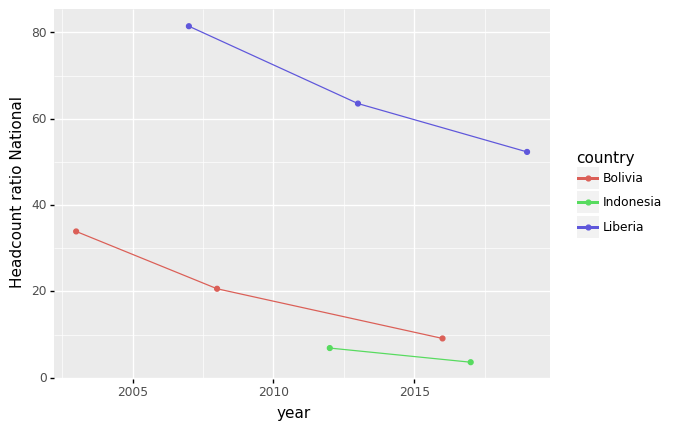

<ggplot: (282361531)>

In [16]:
# select countries to plot
select_countries = ["Bolivia", "Indonesia", "Liberia"]

# filter hot data
chart_df = df_main_hot.loc[df_main_hot['country'].isin(select_countries)]

# plot
(ggplot(chart_df, aes(x='year', y='Headcount ratio National', color='country')) 
     + geom_point()
     + geom_line())



##### `cme` data

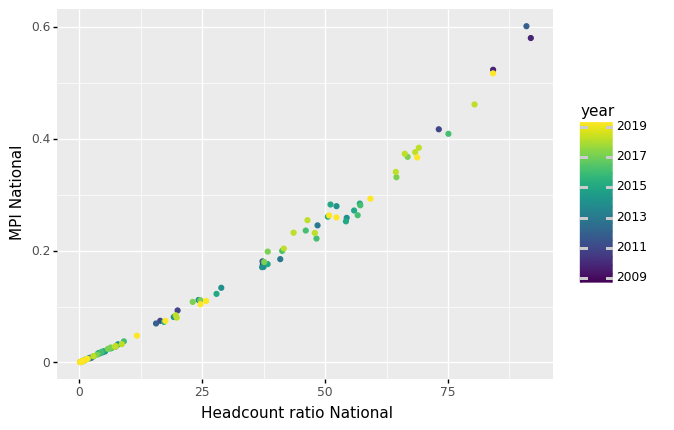

<ggplot: (310599729)>

In [17]:
# plot
(ggplot(df_main_cme, aes(x='Headcount ratio National', y='MPI National', color='year')) 
     + geom_point())

## Other measures

In addition there are a number of measures which are in turn broken down by individual indicators.

In the future we could consider make an explorer to help navigate these (I think OPHI don't have much in the way of this currently).

This includes:

- the share who are poor in that indicator alone
    - `Uncensored headcount ratio` = share who are deprived in that indicator out of the total population
    - `Censored headcount ratio` = share who are deprived in that indicator out of the population who are multidimensionally poor
    
(Note that not all indicators are available for all countries – the composition of the MPI varies according to what's available in the survey data).

In [18]:
df.loc[df['measure_lab'].isin(["Censored headcount ratio", "Uncensored headcount ratio"])]\
   .groupby(['measure_lab', 'ind_lab'], as_index=False).agg({"country":"nunique"})\
   .rename(columns={'country':'unique_countries'})

,measure_lab,ind_lab,unique_countries
0,Censored headcount ratio,Assets,109
1,Censored headcount ratio,Child mortality,104
2,Censored headcount ratio,Cooking fuel,104
3,Censored headcount ratio,Drinking water,109
4,Censored headcount ratio,Electricity,108
5,Censored headcount ratio,Housing,108
6,Censored headcount ratio,Nutrition,100
7,Censored headcount ratio,Sanitation,109
8,Censored headcount ratio,School attendance,108
9,Censored headcount ratio,Years of schooling,109


- The `Absolute` and `Relative contribution` each indicator makes to the MPI measure

In [20]:
# Sum relative contributions by country-year-area-flav
df_rel_sum = df.loc[(df.measure_lab=="Relative contribution") & (df.ind_lab.notnull())]\
    .groupby(['country', 'year', 'area_lab', 'flav'], as_index=False)\
    .agg({"b":"sum"}).rename(columns={'b':'sum_of_relative_contributions'})

# Sum absolute contributions by country-year-area-flav
df_abs_sum = df.loc[(df.measure_lab=="Absolute contribution") & (df.ind_lab.notnull())]\
    .groupby(['country', 'year', 'area_lab', 'flav'], as_index=False)\
    .agg({"b":"sum"}).rename(columns={'b':'sum_of_absolute_contributions'})

# Store MPI by country-year-area-flav
df_MPI = df.loc[(df.measure_lab=="MPI")]\
    .rename(columns={'b':'MPI'})\
    [['country', 'year', 'area_lab', 'flav', 'MPI']]

# Merge the sums with the MPI
df_rel_abs_sums = pd.merge(df_rel_sum,df_abs_sum)
df_rel_abs_sums = pd.merge(df_rel_abs_sums,df_MPI)

print("The sum of relative contributions = 100%; the sum of absolute contributions = MPI")
df_rel_abs_sums.head()


The sum of relative contributions = 100%; the sum of absolute contributions = MPI


,country,year,area_lab,flav,sum_of_relative_contributions,sum_of_absolute_contributions,MPI
0,Afghanistan,2010,National,hot,100.000001,0.438983,0.438983
1,Afghanistan,2010,Rural,hot,100.000000,0.484536,0.484536
2,Afghanistan,2010,Urban,hot,100.000001,0.227851,0.227851
3,Afghanistan,2015,National,cme,100.000001,0.271721,0.271721
4,Afghanistan,2015,National,hot,100.000001,0.352025,0.352025


One mistake in the data (I think) is that there are some `Absolute` and `Relative contribution` rows with no indicator (which I dropped in the previous. There are three 'blanks' for each country-year-area-flav observation.

I think these relate to the relative contribution of the three _dimensions_ of indicators (Health, Education, Living Standards) – see [OPHI's description](https://ophi.org.uk/multidimensional-poverty-index/). But there is no variable that tells you which is which.

In [56]:
df.loc[(df['measure_lab'].isin(["Absolute contribution", "Relative contribution"]))\
           & (~df.ind_lab.notnull())]\
  .head(n=12)

,year,country,area_lab,flav,t,measure_lab,ind_lab,b,se,indicator,measure,survey,loa,w_region,k,wgts,spec,misind_lab
43,2018,Algeria,National,cme,NaN,Relative contribution,NaN,49.301267,NaN,NaN,pctb,MICS,nat,Arab States,33.0,equal,gmpi,NaN
44,2018,Algeria,National,cme,NaN,Relative contribution,NaN,19.484380,NaN,NaN,pctb,MICS,nat,Arab States,33.0,equal,gmpi,NaN
45,2018,Algeria,National,cme,NaN,Relative contribution,NaN,31.214356,NaN,NaN,pctb,MICS,nat,Arab States,33.0,equal,gmpi,NaN
89,2018,Algeria,Urban,cme,NaN,Relative contribution,NaN,50.745237,NaN,NaN,pctb,MICS,area,Arab States,33.0,equal,gmpi,NaN
90,2018,Algeria,Urban,cme,NaN,Relative contribution,NaN,6.808648,NaN,NaN,pctb,MICS,area,Arab States,33.0,equal,gmpi,NaN
91,2018,Algeria,Urban,cme,NaN,Relative contribution,NaN,42.446116,NaN,NaN,pctb,MICS,area,Arab States,33.0,equal,gmpi,NaN
136,2018,Algeria,Rural,cme,NaN,Relative contribution,NaN,24.227709,NaN,NaN,pctb,MICS,area,Arab States,33.0,equal,gmpi,NaN
137,2018,Algeria,Rural,cme,NaN,Relative contribution,NaN,48.760921,NaN,NaN,pctb,MICS,area,Arab States,33.0,equal,gmpi,NaN
138,2018,Algeria,Rural,cme,NaN,Relative contribution,NaN,27.011368,NaN,NaN,pctb,MICS,area,Arab States,33.0,equal,gmpi,NaN
179,2014,Egypt,National,cme,NaN,Relative contribution,NaN,53.080046,NaN,NaN,pctb,DHS,nat,Arab States,33.0,equal,gmpi,Cooking fuel


Finally, `population share` gives the share of national population in each subnational unit.

In [57]:
print("Subnational breakdown of population")
df.loc[(df.measure_lab=="Population share")]\
  .pivot_table(index = ["year","country", "flav"],
              columns = ["area_lab"],
              values = "b",
              margins=True,
              aggfunc='sum').reset_index().head()
       

Subnational breakdown of population


area_lab,year,country,flav,Camp,Rural,Urban,All
0,2000,Central African Republic,hot,NaN,59.563217,40.436783,100.0
1,2000,Gabon,hot,NaN,26.682594,73.317406,100.0
2,2001,Nicaragua,hot,NaN,42.626794,57.373206,100.0
3,2003,Bolivia,hot,NaN,38.285536,61.714464,100.0
4,2003,Mozambique,hot,NaN,66.825503,33.174497,100.0
